In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
%matplotlib inline

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

imputed_data = pd.read_csv("imputed_data.csv")

# Prepare the data
X = imputed_data[['OverallQual','GrLivArea','TotalBsmtSF','1stFlrSF','GarageArea',    
                   'YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtUnfSF','Fireplaces',
                  'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
                  'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 
                  'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 
                  'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 
                  'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 
                  'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 
                  'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
                  'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 
                  'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 
                  'Neighborhood_Veenker']]

y = imputed_data['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the models
mlr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor()
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
lgbm = LGBMRegressor()
mlp = MLPRegressor()
kr = KernelRidge()

# Define base estimators to be used in the ensemble
base_estimators = [('rf', RandomForestRegressor()),
                   ('xgb', XGBRegressor()),
                   ('dt', DecisionTreeRegressor())]

# Define a final estimator to combine the predictions of the base estimators
final_estimator = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                 ('lasso', LassoCV())])

# Define a StackingRegressor object with the base and final estimator
stacked = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True)

# Fit and evaluate each model using cross-validation
models = {'MLR': mlr, 'Ridge': ridge, 'Lasso': lasso, 'Elastic Net': elastic, 'Decision Tree': dt, 'Random Forest': rf, 'XGBoost': xgb, 'SVR': svr, 'Stacked Ensemble': stacked, 'LGBM':lgbm, 'MLP':mlp, 'Kernel Ridge': kr}

# Define an empty list to store the R-squared values for each model
r2_values_train = []
r2_values_test = []

metrics_dict = {}
for name, model in tqdm(models.items(), desc="Processing models"):
    metrics_dict[name] = []
    
    # Evaluate the model using cross-validation on the training set
    mae_train = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    mape_train = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_percentage_error')
    r2_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').flatten()  # use flatten() here
    
    # Evaluate the model on the test set
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    r2_test = r2_score(y_test, y_pred_test)
    
    metrics_dict[name].extend([mae_train.mean(), mape_train.mean(), r2_train.mean(), mae_test, mape_test, r2_test])
    r2_values_train.append(r2_train.flatten())  # use flatten() here
    r2_values_test.append(r2_test)

# Create a DataFrame and print the results
metrics_df = pd.DataFrame(metrics_dict, index=['MAE Train', 'MAPE Train', 'R^2 Train', 'MAE Test', 'MAPE Test', 'R^2 Test']).T
metrics_df.index.name = 'Model'
print(metrics_df.to_string())


Processing models: 100%|███████████████████████████████████████████████████████████████| 12/12 [05:50<00:00, 29.24s/it]

                     MAE Train  MAPE Train  R^2 Train      MAE Test  MAPE Test  R^2 Test
Model                                                                                   
MLR               22648.955223    0.138401   0.838378  25033.425933  17.058764  0.771659
Ridge             22819.236464    0.137685   0.842664  25010.592660  17.045406  0.771847
Lasso             22679.335052    0.136973   0.843907  25028.210826  17.054787  0.771708
Elastic Net       22568.058143    0.134274   0.839082  25094.676783  17.344707  0.768068
Decision Tree      9457.623800    0.048494   0.911269   4813.266150   4.694383  0.969127
Random Forest      9746.021082    0.058773   0.940620   9249.916130   8.097636  0.953611
XGBoost            7859.173391    0.048813   0.952008   5520.561370   5.585021  0.977679
SVR               56900.303229    0.304898  -0.068372  58369.694049  38.396337 -0.045653
Stacked Ensemble   8213.969014    0.047911   0.950783   5636.365678   5.643822  0.978013
LGBM              105

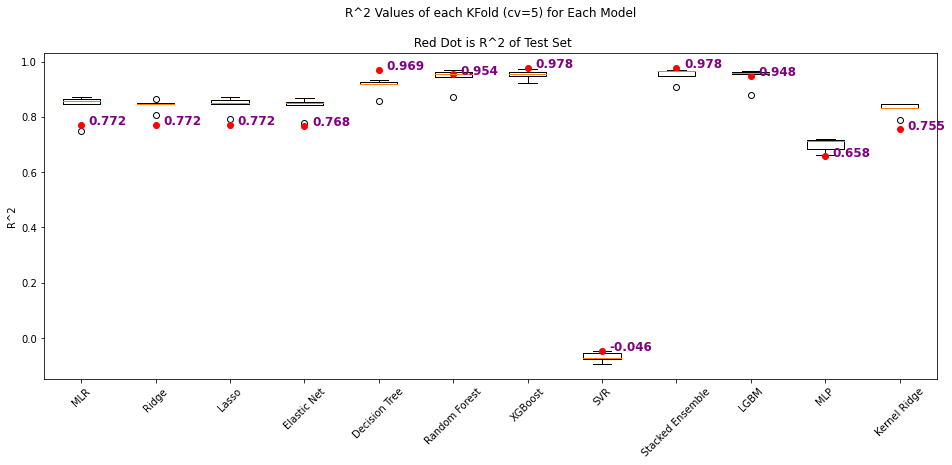

The best performing model is Stacked Ensemble, with an R^2 score of 0.978.


In [3]:
fig, ax = plt.subplots(figsize=(16, 6))

# Boxplot of R^2 values for each model
bp = ax.boxplot(r2_values_train, labels=list(models.keys()))

# Set the label of the y-axis
ax.set_ylabel('R^2')

# Set the title of the plot
ax.set_title('R^2 Values of each KFold (cv=5) for Each Model\n\n Red Dot is R^2 of Test Set')

# Plot a red dot of the R^2 of the test set
for i in range(len(r2_values_test)):
    ax.plot(i+1, r2_values_test[i], 'ro')
    ax.annotate(round(r2_values_test[i], 3), (i+1.1, r2_values_test[i]), fontsize=12, color='purple', fontweight='bold')

# Set the x-ticks to the model names
plt.xticks(np.arange(1, len(models) + 1), list(models.keys()), rotation=45)

# Show the plot
plt.show()

best_model = metrics_df['R^2 Test'].idxmax()
best_r2_score = metrics_df.loc[best_model, 'R^2 Test']

print(f'The best performing model is {best_model}, with an R^2 score of {best_r2_score:.3f}.')

In [4]:
# Find the model with the lowest MAE
min_mae_model = metrics_df['MAE Test'].idxmin()
min_mae_value = metrics_df.loc[min_mae_model, 'MAE Test']

# Find the model with the lowest MAPE
min_mape_model = metrics_df['MAPE Test'].idxmin()
min_mape_value = metrics_df.loc[min_mape_model, 'MAPE Test']

# Find the model with the highest R^2
max_r2_model = metrics_df['R^2 Test'].idxmax()
max_r2_value = metrics_df.loc[max_r2_model, 'R^2 Test']

print(f"Best performing model based on lowest MAE: {min_mae_model} (MAE={min_mae_value:.2f})")
print(f"Best performing model based on lowest MAPE: {min_mape_model} (MAPE={min_mape_value:.2%})")
print(f"Best performing model based on highest R^2: {max_r2_model} (R^2={max_r2_value:.2f})")

Best performing model based on lowest MAE: Decision Tree (MAE=4813.27)
Best performing model based on lowest MAPE: Decision Tree (MAPE=469.44%)
Best performing model based on highest R^2: Stacked Ensemble (R^2=0.98)


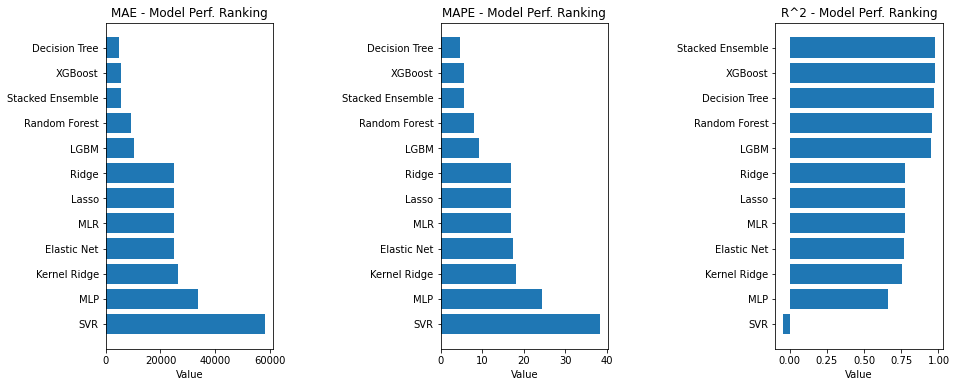

In [5]:
# Extract the metrics for each model
mae_values = metrics_df['MAE Test'].values
mape_values = metrics_df['MAPE Test'].values
r2_values = metrics_df['R^2 Test'].values
labels = metrics_df.index.values

# Sort the metrics in the desired order
mae_idx = mae_values.argsort()[::-1]
mape_idx = mape_values.argsort()[::-1]
r2_idx = r2_values.argsort()

# Set up the figure
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Create bar charts for each metric
axs[0].barh(labels[mae_idx], mae_values[mae_idx])
axs[0].set_title('MAE - Model Perf. Ranking')
axs[0].set_xlabel('Value')
axs[1].barh(labels[mape_idx], mape_values[mape_idx])
axs[1].set_title('MAPE - Model Perf. Ranking')
axs[1].set_xlabel('Value')
axs[2].barh(labels[r2_idx], r2_values[r2_idx])
axs[2].set_title('R^2 - Model Perf. Ranking')
axs[2].set_xlabel('Value')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=1)

# Show the plot
plt.show()

Stacking is a method that combines multiple models to improve the overall predictive performance. The idea behind stacking is that by combining the predictions of several models, we can take advantage of their strengths and compensate for their weaknesses, resulting in a more accurate and robust model.

In a stacked ensemble, the base models should ideally be models that are individually strong, diverse, and complementary to each other. If a model has a lower performance compared to other models, it may not be as useful in improving the overall performance of the ensemble.

For example, a Decision Tree may be good at capturing complex non-linear relationships in the data, but may overfit and generalize poorly to new data. By combining it with other models, such as a Random Forest or an XGBoost, which are good at reducing overfitting and improving generalization, we may be able to achieve a better overall performance.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import lightgbm as lgb
import matplotlib.pyplot as plt

imputed_data = pd.read_csv("imputed_data.csv")

# Define feature sets
feature_sets = {
    "four_best": imputed_data[['OverallQual','GrLivArea','TotalBsmtSF','1stFlrSF']],
    "ten_best": imputed_data[['OverallQual','GrLivArea','TotalBsmtSF','1stFlrSF','GarageArea',    
                   'YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtUnfSF','Fireplaces']]
}

# add stacked ensemble next

# Define regression models
regression_models = {
    "MLR" : LinearRegression(),
    "Ridge" : Ridge(),
    "Lasso" : Lasso(),
    "ElasticNet" : ElasticNet(),
    "DecisionTree" : DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
    "SVR": SVR(),
    "Stacked": StackingRegressor(estimators=base_estimators, final_estimator=final_estimator),
    "KernelRidge":KernelRidge()
}

# Define base estimators to be used in the ensemble
base_estimators = [('rf', RandomForestRegressor()),
                   ('xgb', XGBRegressor()),
                   ('dt', DecisionTreeRegressor())]

# Define a final estimator to combine the predictions of the base estimators
final_estimator = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                 ('lasso', LassoCV())])

# Define a StackingRegressor object with the base and final estimator
stacked = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator)

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True)

# Define function to fit and evaluate each model using cross-validation
def make_regression(x, y, model, model_name, verbose=True):
    mae = -cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error')
    r2 = cross_val_score(model, x, y, cv=cv, scoring='r2')
    
    if verbose:
        print("----Model name = {}-----".format(model_name))
        print("Mean MAE = "'{}'.format(mae.mean()))
        print("Mean R^2 = "'{}'.format(r2.mean()))
        print("--------------------------------")
    
    trained_model = model.fit(x, y)
    
    return trained_model, mae.mean(), r2.mean()

# Initialize dictionary to store prediction results
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "MAE": [],
    "R2": [],
    "Train Error": [],
    "Test Error": []
}

# Fit and evaluate each model using cross-validation for each feature set
for feature_set_name in tqdm(feature_sets.keys(), desc="Processing feature sets"):
    feature_set = feature_sets[feature_set_name]
    print("Included columns are {}".format(feature_set_name))
    for model_name in tqdm(regression_models.keys(), desc="Processing models"):
        y = imputed_data["SalePrice"]
        x = feature_set
        trained_model, mae, r2 = make_regression(x, y, regression_models[model_name], model_name, verbose=True)
        pred_dict["regression_model"].append(model_name)
        pred_dict["feature_set"].append(feature_set_name)
        pred_dict["MAE"].append(mae)
        pred_dict["R2"].append(r2)
        
        # calculate train error and append it to the dictionary
        y_train_pred = trained_model.predict(x)
        train_error = mean_absolute_error(y, y_train_pred)
        pred_dict["Train Error"].append(train_error)

        # calculate test error and append it to the dictionary
        test_error = -cross_val_score(trained_model, x, y, cv=cv, scoring='neg_mean_absolute_error').mean()
        pred_dict["Test Error"].append(test_error)

# Create a dataframe and reshape it to a bar chart format
pred_df = pd.DataFrame.from_dict(pred_dict)

# Pivot the dataframe to reshape it to a bar chart format
df_barh = pred_df.pivot(index='feature_set', columns='regression_model', values='R2')
df_train = pred_df.pivot(index='feature_set', columns='regression_model', values='Train Error')
df_test = pred_df.pivot(index='feature_set', columns='regression_model', values='Test Error')


Processing models:   8%|█████▎                                                          | 1/12 [00:00<00:01,  8.98it/s]

Included columns are four_best
----Model name = MLR-----
Mean MAE = 26580.008741394304
Mean R^2 = 0.7736620527453782
--------------------------------
----Model name = Ridge-----
Mean MAE = 26599.765857924416
Mean R^2 = 0.7775760058028378
--------------------------------



Processing models:  33%|█████████████████████▎                                          | 4/12 [00:00<00:00,  8.91it/s]

----Model name = Lasso-----
Mean MAE = 26570.424939230095
Mean R^2 = 0.7781207170909237
--------------------------------
----Model name = ElasticNet-----
Mean MAE = 26709.454299941193
Mean R^2 = 0.7669761256641889
--------------------------------



Processing models:  42%|██████████████████████████▋                                     | 5/12 [00:00<00:00,  8.11it/s]

----Model name = DecisionTree-----
Mean MAE = 21141.283619208512
Mean R^2 = 0.8729885631074495
--------------------------------
----Model name = RandomForest-----
Mean MAE = 8661.416285183568
Mean R^2 = 0.9676218362892843
--------------------------------



Processing models:  50%|████████████████████████████████                                | 6/12 [00:13<00:23,  3.89s/it]

----Model name = XGBoost-----
Mean MAE = 7752.032768214027
Mean R^2 = 0.9715941581455814
--------------------------------



Processing models:  58%|█████████████████████████████████████▎                          | 7/12 [00:16<00:18,  3.63s/it]

----Model name = LGBM-----
Mean MAE = 15849.936709413058
Mean R^2 = 0.9195809815623364
--------------------------------



Processing models:  67%|██████████████████████████████████████████▋                     | 8/12 [00:18<00:12,  3.16s/it]

----Model name = MLP-----
Mean MAE = 35092.20987873247
Mean R^2 = 0.6376252542664614
--------------------------------



Processing models:  75%|████████████████████████████████████████████████                | 9/12 [00:50<00:35, 11.95s/it]

----Model name = SVR-----
Mean MAE = 58079.62280002849
Mean R^2 = -0.07070480569845974
--------------------------------



Processing models:  83%|████████████████████████████████████████████████████▌          | 10/12 [00:57<00:20, 10.28s/it]

----Model name = Stacked-----
Mean MAE = 10290.894629929164
Mean R^2 = 0.9649182218052316
--------------------------------



Processing models:  92%|█████████████████████████████████████████████████████████▊     | 11/12 [02:33<00:35, 35.96s/it]

----Model name = KernelRidge-----
Mean MAE = 32506.56172369432
Mean R^2 = 0.6810887654496962
--------------------------------



Processing models:   8%|█████▎                                                          | 1/12 [00:00<00:01,  5.78it/s]

Included columns are ten_best
----Model name = MLR-----
Mean MAE = 23215.350264388922
Mean R^2 = 0.8209628776912513
--------------------------------



Processing models:  17%|██████████▋                                                     | 2/12 [00:00<00:01,  5.93it/s]

----Model name = Ridge-----
Mean MAE = 23128.647938100945
Mean R^2 = 0.8221104688942805
--------------------------------



Processing models:  25%|████████████████                                                | 3/12 [00:00<00:01,  4.63it/s]

----Model name = Lasso-----
Mean MAE = 23140.08528518682
Mean R^2 = 0.8208334899308916
--------------------------------



Processing models:  33%|█████████████████████▎                                          | 4/12 [00:00<00:01,  4.01it/s]

----Model name = ElasticNet-----
Mean MAE = 23226.271533677293
Mean R^2 = 0.8144685148129571
--------------------------------



Processing models:  42%|██████████████████████████▋                                     | 5/12 [00:01<00:01,  4.11it/s]

----Model name = DecisionTree-----
Mean MAE = 19030.13695210138
Mean R^2 = 0.8902009366041821
--------------------------------
----Model name = RandomForest-----
Mean MAE = 6368.452453004576
Mean R^2 = 0.9708906996401991
--------------------------------



Processing models:  50%|████████████████████████████████                                | 6/12 [00:25<00:44,  7.42s/it]

----Model name = XGBoost-----
Mean MAE = 3632.036465525073
Mean R^2 = 0.982420584655817
--------------------------------



Processing models:  58%|█████████████████████████████████████▎                          | 7/12 [00:29<00:31,  6.36s/it]

----Model name = LGBM-----
Mean MAE = 8798.01495573839
Mean R^2 = 0.9704150377267554
--------------------------------



Processing models:  67%|██████████████████████████████████████████▋                     | 8/12 [00:32<00:21,  5.32s/it]

----Model name = MLP-----
Mean MAE = 30329.60263627064
Mean R^2 = 0.7198228921657328
--------------------------------



Processing models:  75%|████████████████████████████████████████████████                | 9/12 [01:05<00:40, 13.60s/it]

----Model name = SVR-----
Mean MAE = 58140.85705614426
Mean R^2 = -0.07070525956101967
--------------------------------



Processing models:  83%|████████████████████████████████████████████████████▌          | 10/12 [02:07<00:56, 28.26s/it]

----Model name = Stacked-----
Mean MAE = 5872.802986476713
Mean R^2 = 0.9812516127919186
--------------------------------



Processing models:  92%|█████████████████████████████████████████████████████████▊     | 11/12 [04:42<01:06, 66.22s/it]

----Model name = KernelRidge-----
Mean MAE = 24497.58498376654
Mean R^2 = 0.8110254777803301
--------------------------------



Processing feature sets: 100%|██████████████████████████████████████████████████████████| 2/2 [07:25<00:00, 222.77s/it]


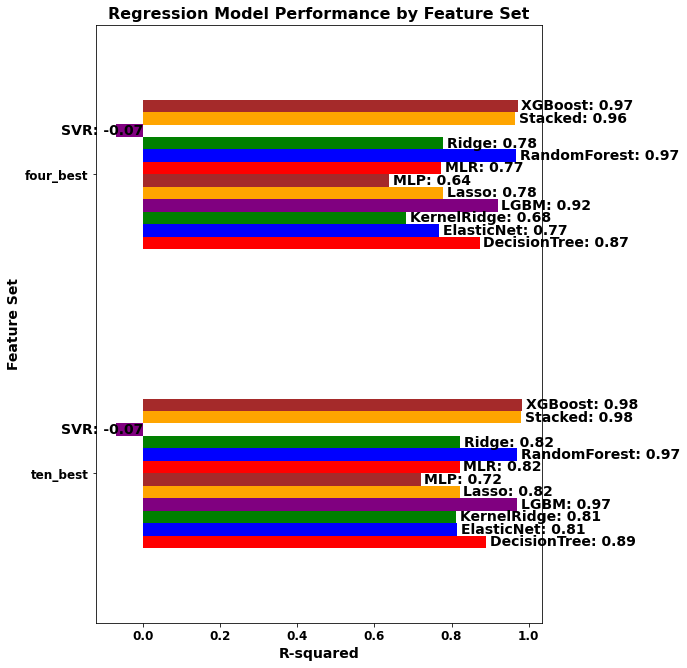

Highest performing model based on maximizing R^2 for ten_best: XGBoost (0.98)
Highest performing model based on maximizing R^2 for four_best: XGBoost (0.97)


In [7]:
def add_bar_labels(ax, model_names):
    for i, bar in enumerate(ax.patches):
        # Get the bar's width and position
        width = bar.get_width()
        y_pos = bar.get_y()

        # Define the label's position and alignment
        label_x_pos = (width + 0.01) if width >= 0 else 0
        label_align = 'left' if width >= 0 else 'right'

        # Find the correct model name using row and column indices
        row_idx = i % len(df_barh.index)
        col_idx = i // len(df_barh.index)
        model_name = model_names[col_idx]

        # Add the label to the bar with the model name
        label_text = f'{model_name}: {bar.get_width():.2f}'
        ax.text(label_x_pos, y_pos + bar.get_height() / 2, label_text, va='center', ha=label_align, color='black', fontsize=14, fontweight='bold')

# Sort the DataFrame by the maximum R-squared value in each row
df_barh = df_barh.loc[df_barh.max(axis=1).sort_values(ascending=False).index]

# Create a figure
fig, ax = plt.subplots(figsize=(8, 11))

# Plot the bar chart without legend
df_barh.plot(kind='barh', ax=ax, color=['red', 'blue', 'green', 'purple', 'orange', 'brown'], legend=False)

# Set title and labels with custom font size and weight
ax.set_title('Regression Model Performance by Feature Set', fontsize=16, fontweight='bold')
ax.set_xlabel('R-squared', fontsize=14, fontweight='bold')
ax.set_ylabel('Feature Set', fontsize=14, fontweight='bold')

# Update x and y tick labels with custom font size and weight
ax.tick_params(axis='x', labelsize=12, labelrotation=0)
ax.tick_params(axis='y', labelsize=12, labelrotation=0)
plt.setp(ax.get_xticklabels(), fontweight='bold')
plt.setp(ax.get_yticklabels(), fontweight='bold')

# Set y-tick locations manually
ax.set_yticks(range(len(df_barh.index)))

# Set y-tick labels manually
ax.set_yticklabels(df_barh.index)

# Add labels to the bars
model_names = df_barh.columns.tolist()
add_bar_labels(ax, model_names)

# Show the figure
plt.show()

# Get highest performing model for each feature set
best_models = df_barh.idxmax(axis=1)

# Get performance of highest performing model for each feature set
best_performances = df_barh.max(axis=1)

# Print results
for i, feature_set in enumerate(df_barh.index):
    print(f'Highest performing model based on maximizing R^2 for {feature_set}: {best_models[i]} ({best_performances[i]:.2f})')

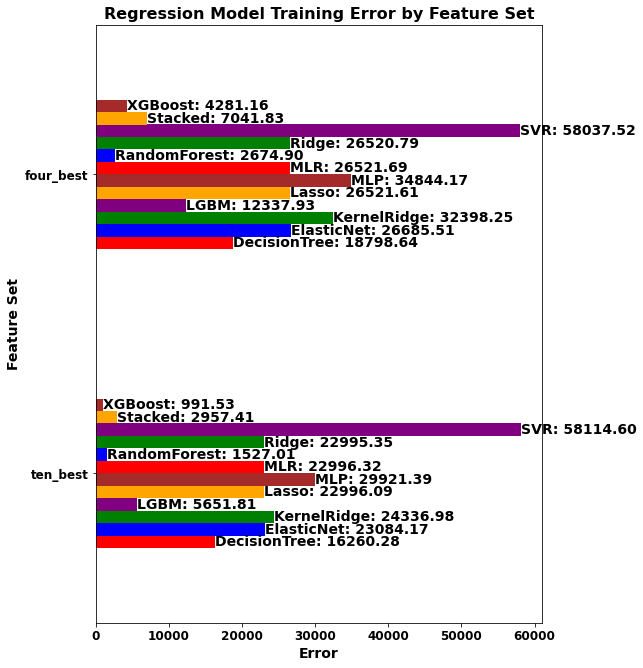

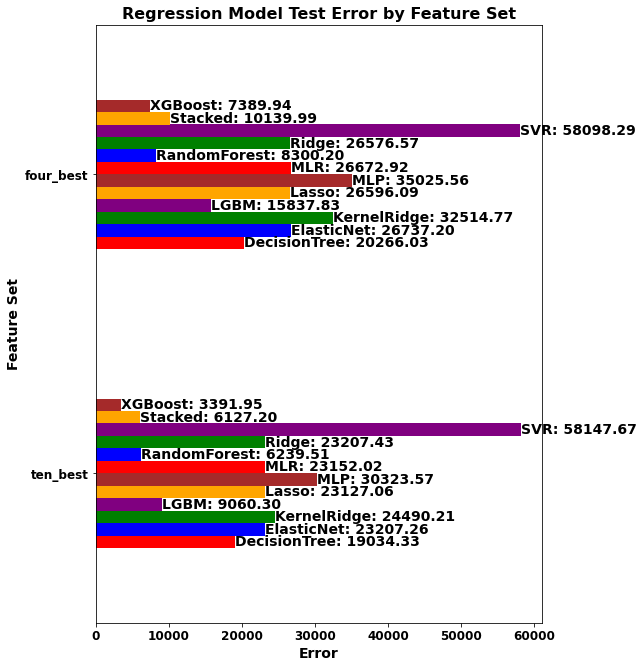

Best Model that Minimizes Training Error:
four_best: RandomForest (2674.90)
ten_best: XGBoost (991.53)


Best Model that Minimizes Test Error:
four_best: XGBoost (7389.94)
ten_best: XGBoost (3391.95)


In [8]:
# Create a function to generate the charts
def create_chart(df, chart_title):
    # Sort the DataFrame by the maximum value in each row
    df = df.loc[df.max(axis=1).sort_values(ascending=False).index]

    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 11))

    # Plot the bar chart without legend
    df.plot(kind='barh', ax=ax, color=['red', 'blue', 'green', 'purple', 'orange', 'brown'], legend=False)

    # Set title and labels with custom font size and weight
    ax.set_title(chart_title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Error', fontsize=14, fontweight='bold')
    ax.set_ylabel('Feature Set', fontsize=14, fontweight='bold')

    # Update x and y tick labels with custom font size and weight
    ax.tick_params(axis='x', labelsize=12, labelrotation=0)
    ax.tick_params(axis='y', labelsize=12, labelrotation=0)
    plt.setp(ax.get_xticklabels(), fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')

    # Set y-tick locations manually
    ax.set_yticks(range(len(df.index)))

    # Set y-tick labels manually
    ax.set_yticklabels(df.index)

    # Add labels to the bars
    model_names = df.columns.tolist()
    add_bar_labels(ax, model_names)

    # Show the figure
    plt.show()

# Create charts for df_train and df_test
create_chart(df_train, 'Regression Model Training Error by Feature Set')
create_chart(df_test, 'Regression Model Test Error by Feature Set')

# Get models with the minimum training error for each feature set
min_train_error_models = df_train.idxmin(axis=1)

# Get the minimum training error for each feature set
min_train_errors = df_train.min(axis=1)

# Print results
print("Best Model that Minimizes Training Error:")
for i, feature_set in enumerate(df_train.index):
    print(f'{feature_set}: {min_train_error_models[i]} ({min_train_errors[i]:.2f})')

print("\n")

# Get models with the minimum test error for each feature set
min_test_error_models = df_test.idxmin(axis=1)

# Get the minimum test error for each feature set
min_test_errors = df_test.min(axis=1)

# Print results
print("Best Model that Minimizes Test Error:")
for i, feature_set in enumerate(df_test.index):
    print(f'{feature_set}: {min_test_error_models[i]} ({min_test_errors[i]:.2f})')